In [8]:
from functools import partial
from collections import defaultdict
import pydicom
import os
import glob
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

np.warnings.filterwarnings('ignore')

In [10]:
labels = pd.read_csv('stage_2_train_labels.csv')
details = pd.read_csv('stage_2_detailed_class_info.csv')
# duplicates in details just have the same class so can be safely dropped
details = details.drop_duplicates('patientId').reset_index(drop=True)
labels_w_class = labels.merge(details, how='inner', on='patientId')

In [11]:
# get lists of all train/test dicom filepaths
train_dcm_fps = glob.glob('stage_2_train_images/*.dcm')
test_dcm_fps = glob.glob('stage_2_test_images/*.dcm')

# read each file into a list (using stop_before_pixels to avoid reading the image for speed and memory savings)
train_dcms = [pydicom.read_file(x, stop_before_pixels=True) for x in train_dcm_fps]
test_dcms = [pydicom.read_file(x, stop_before_pixels=True) for x in test_dcm_fps]

In [12]:
def parse_dcm_metadata(dcm):
    unpacked_data = {}
    group_elem_to_keywords = {}
    # iterating here to force conversion from lazy RawDataElement to DataElement
    for d in dcm:
        pass
    # keys are pydicom.tag.BaseTag, values are pydicom.dataelem.DataElement
    for tag, elem in dcm.items():
        tag_group = tag.group
        tag_elem = tag.elem
        keyword = elem.keyword
        group_elem_to_keywords[(tag_group, tag_elem)] = keyword
        value = elem.value
        unpacked_data[keyword] = value
    return unpacked_data, group_elem_to_keywords

train_meta_dicts, tag_to_keyword_train = zip(*[parse_dcm_metadata(x) for x in train_dcms])
test_meta_dicts, tag_to_keyword_test = zip(*[parse_dcm_metadata(x) for x in test_dcms])

In [13]:
# join all the dicts
unified_tag_to_key_train = {k:v for dict_ in tag_to_keyword_train for k,v in dict_.items()}
unified_tag_to_key_test = {k:v for dict_ in tag_to_keyword_test for k,v in dict_.items()}

# quick check to make sure there are no different keys between test/train
assert len(set(unified_tag_to_key_test.keys()).symmetric_difference(set(unified_tag_to_key_train.keys()))) == 0

tag_to_key = {**unified_tag_to_key_test, **unified_tag_to_key_train}
tag_to_key

{(8, 5): 'SpecificCharacterSet',
 (8, 22): 'SOPClassUID',
 (8, 24): 'SOPInstanceUID',
 (8, 32): 'StudyDate',
 (8, 48): 'StudyTime',
 (8, 80): 'AccessionNumber',
 (8, 96): 'Modality',
 (8, 100): 'ConversionType',
 (8, 144): 'ReferringPhysicianName',
 (8, 4158): 'SeriesDescription',
 (16, 16): 'PatientName',
 (16, 32): 'PatientID',
 (16, 48): 'PatientBirthDate',
 (16, 64): 'PatientSex',
 (16, 4112): 'PatientAge',
 (24, 21): 'BodyPartExamined',
 (24, 20737): 'ViewPosition',
 (32, 13): 'StudyInstanceUID',
 (32, 14): 'SeriesInstanceUID',
 (32, 16): 'StudyID',
 (32, 17): 'SeriesNumber',
 (32, 19): 'InstanceNumber',
 (32, 32): 'PatientOrientation',
 (40, 2): 'SamplesPerPixel',
 (40, 4): 'PhotometricInterpretation',
 (40, 16): 'Rows',
 (40, 17): 'Columns',
 (40, 48): 'PixelSpacing',
 (40, 256): 'BitsAllocated',
 (40, 257): 'BitsStored',
 (40, 258): 'HighBit',
 (40, 259): 'PixelRepresentation',
 (40, 8464): 'LossyImageCompression',
 (40, 8468): 'LossyImageCompressionMethod'}

In [14]:
# using from_records here since some values in the dicts will be iterables and some are constants
train_df = pd.DataFrame.from_records(data=train_meta_dicts)
test_df = pd.DataFrame.from_records(data=test_meta_dicts)
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
df = pd.concat([train_df, test_df])

In [15]:
df.head(1)

,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ConversionType,HighBit,InstanceNumber,LossyImageCompression,LossyImageCompressionMethod,...,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition,dataset
0,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: PA,1.2.276.0.7230010.3.1.3.8323329.28530.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.28530.15178744...,000000.00,PA,train


In [16]:
# separating PixelSpacing list to single values
df['PixelSpacing_x'] = df['PixelSpacing'].apply(lambda x: x[0])
df['PixelSpacing_y'] = df['PixelSpacing'].apply(lambda x: x[1])
df = df.drop(['PixelSpacing'], axis='columns')

# x and y are always the same
assert sum(df['PixelSpacing_x'] != df['PixelSpacing_y']) == 0

In [17]:
# ReferringPhysicianName appears to just be empty strings
assert sum(df['ReferringPhysicianName'] != '') == 0

# SeriesDescription appears to be 'view: {}'.format(ViewPosition)
set(df['SeriesDescription'].unique())

# so these two columns don't have any useful info and can be safely dropped

{'view: AP', 'view: PA'}

In [18]:
nunique_all = df.aggregate('nunique')
nunique_all

AccessionNumber                    1
BitsAllocated                      1
BitsStored                         1
BodyPartExamined                   1
Columns                            1
ConversionType                     1
HighBit                            1
InstanceNumber                     1
LossyImageCompression              1
LossyImageCompressionMethod        1
Modality                           1
PatientAge                        98
PatientBirthDate                   1
PatientID                      29684
PatientName                    29684
PatientOrientation                 1
PatientSex                         2
PhotometricInterpretation          1
PixelRepresentation                1
ReferringPhysicianName          8852
Rows                               1
SOPClassUID                        1
SOPInstanceUID                 29684
SamplesPerPixel                    1
SeriesDescription                  2
SeriesInstanceUID              29684
SeriesNumber                       1
S

In [19]:
# drop constant cols and other two from above
df = df.drop(nunique_all[nunique_all == 1].index.tolist() + ['ReferringPhysicianName', 'SeriesDescription'], axis='columns')

# now that we have a clean metadata dataframe we can merge back to our initial tabular data with target and class info
df = df.merge(labels_w_class, how='left', left_on='PatientID', right_on='patientId')

df['PatientAge'] = df['PatientAge'].astype(int)

In [20]:
# df now has multiple rows for some patients (those with multiple bounding boxes in label_w_class)
# so creating one with no duplicates for patients
df_deduped = df.drop_duplicates('PatientID', keep='first')

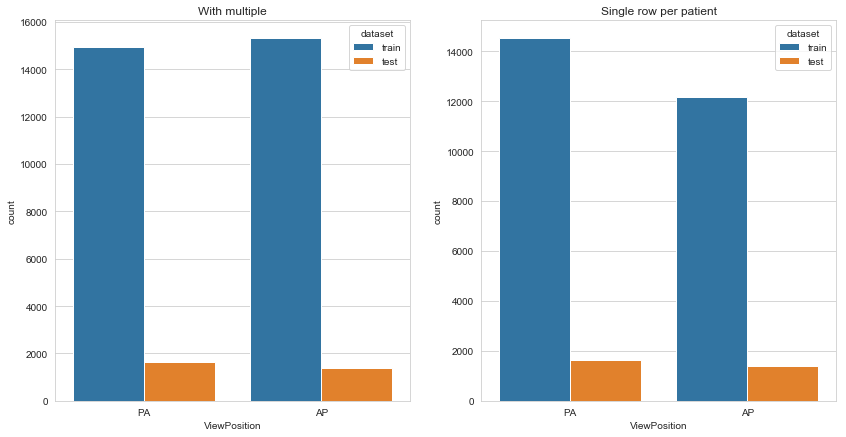

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='dataset', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='ViewPosition', hue='dataset', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

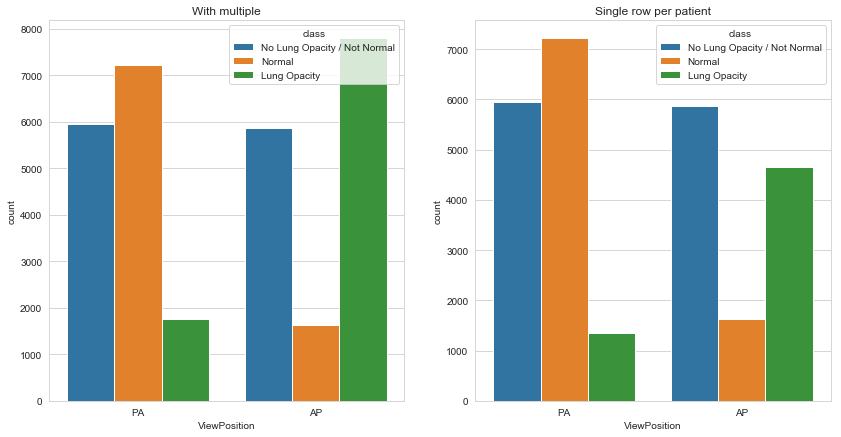

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='class', data=df[df['dataset']=='train'], ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='ViewPosition', hue='class', data=df_deduped[df_deduped['dataset']=='train'], ax=axes[1])
_ = p.set_title('Single row per patient')

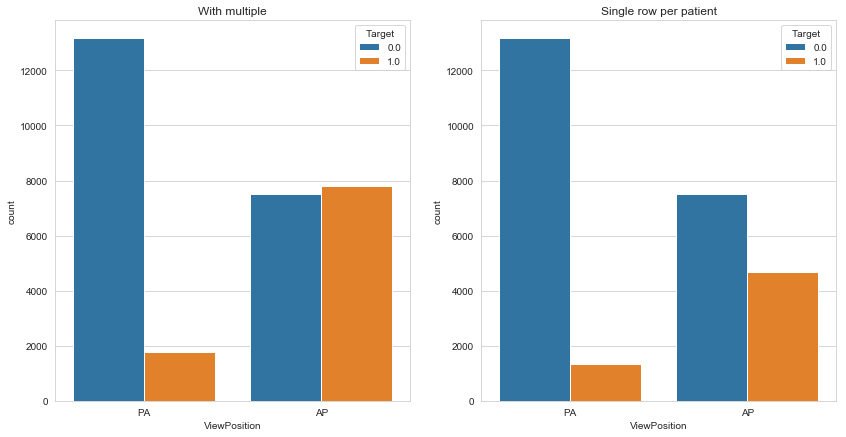

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='Target', data=df[df['dataset']=='train'], ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='ViewPosition', hue='Target', data=df_deduped[df_deduped['dataset']=='train'], ax=axes[1])
_ = p.set_title('Single row per patient')

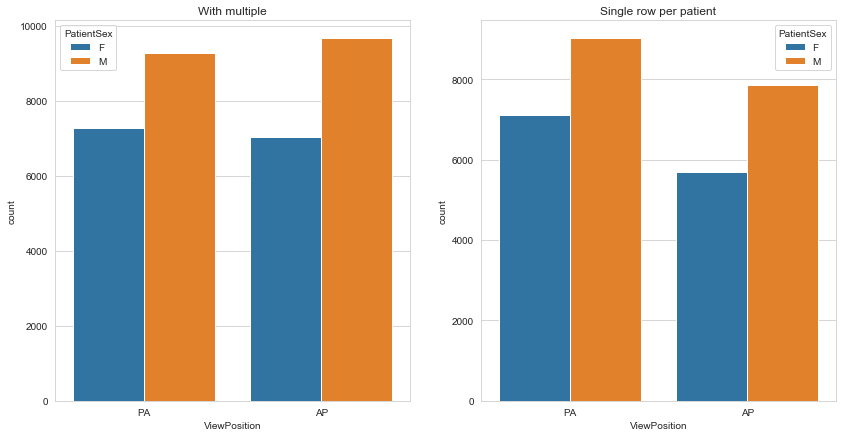

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='PatientSex', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='ViewPosition', hue='PatientSex', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

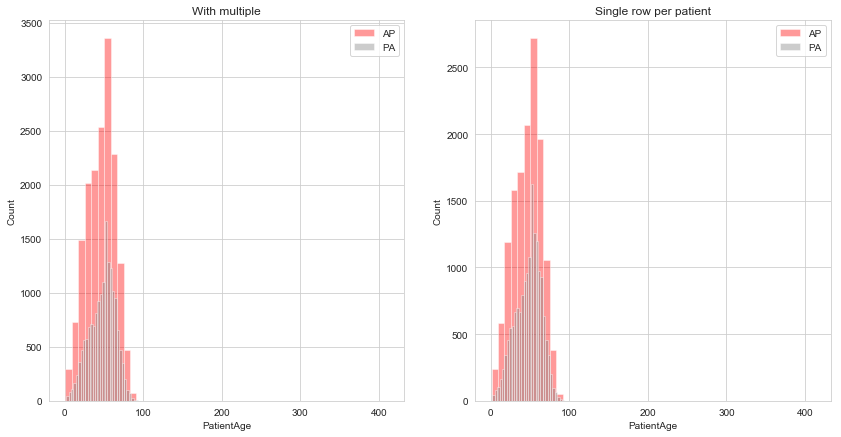

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(df[df['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[0])
p = sns.distplot(df[df['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('With multiple')

p = sns.distplot(df_deduped[df_deduped['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[1])
p = sns.distplot(df_deduped[df_deduped['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Single row per patient')

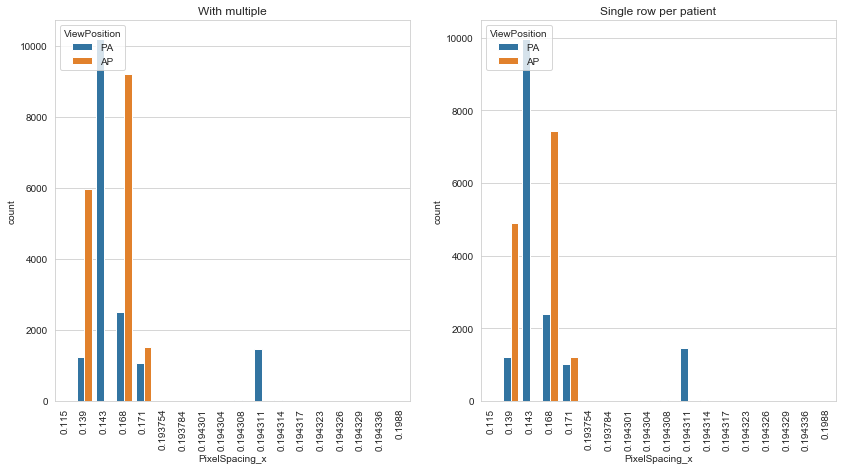

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.countplot(df['PixelSpacing_x'], hue='ViewPosition', data=df, ax=axes[0])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('With multiple')

p = sns.countplot(df_deduped['PixelSpacing_x'], hue='ViewPosition', data=df_deduped, ax=axes[1])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('Single row per patient')

In [27]:
def read_img(patient_id):
    train_fp = 'stage_2_train_images/{}.dcm'.format(patient_id)
    if os.path.exists(train_fp):
        dcm = pydicom.read_file(train_fp)
    else:
        test_fp = 'stage_2_test_images/{}.dcm'.format(patient_id)
        dcm = pydicom.read_file(test_fp)
    return dcm

In [28]:
def plot_grid(df, pid_sample_list, nrows=3, ncols=3, draw_bbox=True, ax_off=True):
    fig = plt.figure(figsize=(16, 12))
    for i in range(nrows * ncols):
        patient_id = pid_sample_list[i]
        img = read_img(patient_id).pixel_array
        ax = fig.add_subplot(nrows, ncols, i + 1)
        plt.imshow(img, cmap='gray')
        ax.set_title(patient_id)
        if ax_off: 
            ax.set_axis_off()
        if draw_bbox:
            bbox_rows = df[df['PatientID'] == patient_id]
            for _, row in bbox_rows.iterrows():
                x, y = row['x'], row['y']
                width, height = row['width'], row['height']
                bbox = patches.Rectangle((x, y), width, height, linewidth=.5, edgecolor='r', facecolor='none')
                ax.add_patch(bbox)
    plt.tight_layout()
    plt.subplots_adjust(wspace=.01, hspace=.01)
    return fig

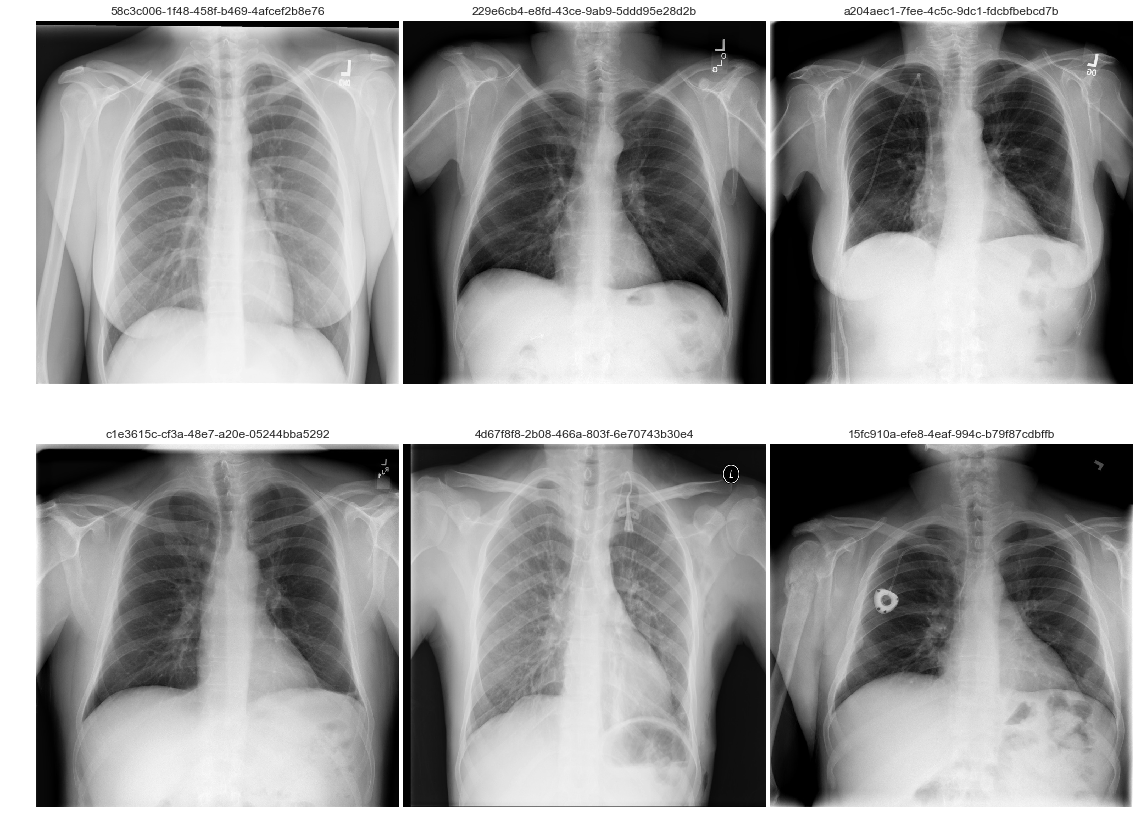

In [29]:
pa_ids = df[df['ViewPosition']=='PA']['PatientID'].sample(20).tolist()
_ = plot_grid(df, pa_ids, nrows=2, ncols=3)

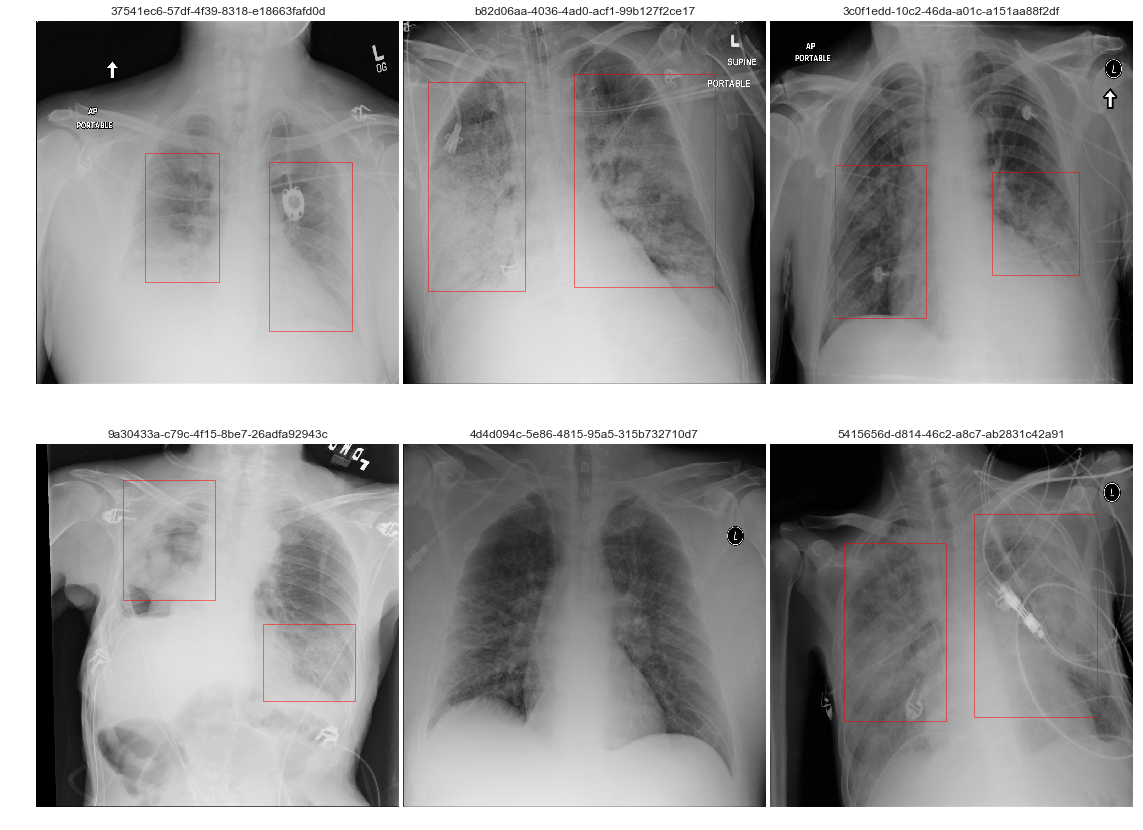

In [30]:
ap_ids = df[df['ViewPosition']=='AP']['PatientID'].sample(20).tolist()
_ = plot_grid(df, ap_ids, nrows=2, ncols=3)

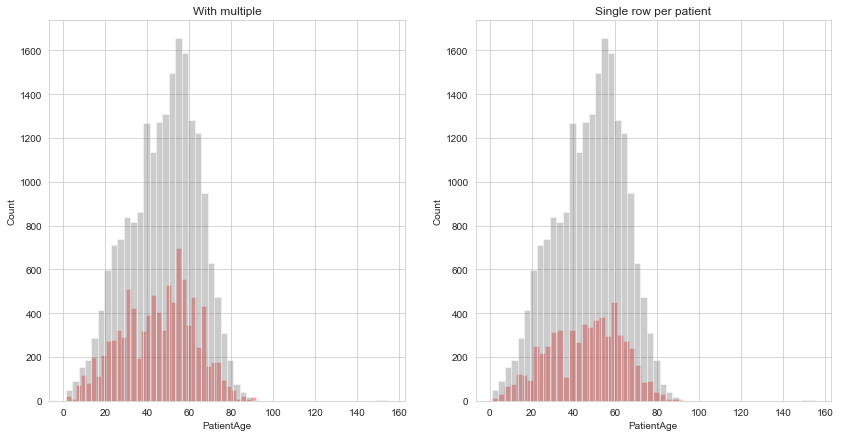

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(df[df['Target']==1]['PatientAge'], hist=True, kde=False, color='red', label='Target 1', ax=axes[0])
p = sns.distplot(df[df['Target']==0]['PatientAge'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.set_title('With multiple')

p = sns.distplot(df_deduped[df_deduped['Target']==1]['PatientAge'], hist=True, kde=False, color='red', label='Target 1', ax=axes[1])
p = sns.distplot(df_deduped[df_deduped['Target']==0]['PatientAge'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.set_title('Single row per patient')

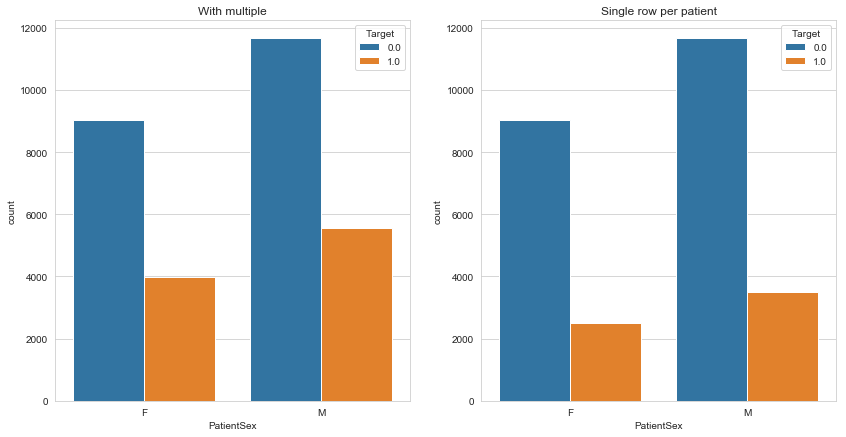

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='PatientSex', hue='Target', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='PatientSex', hue='Target', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')


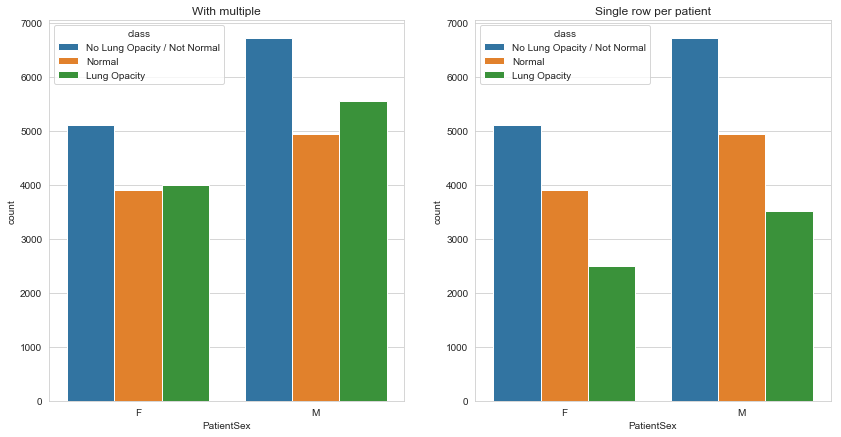

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='PatientSex', hue='class', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='PatientSex', hue='class', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')


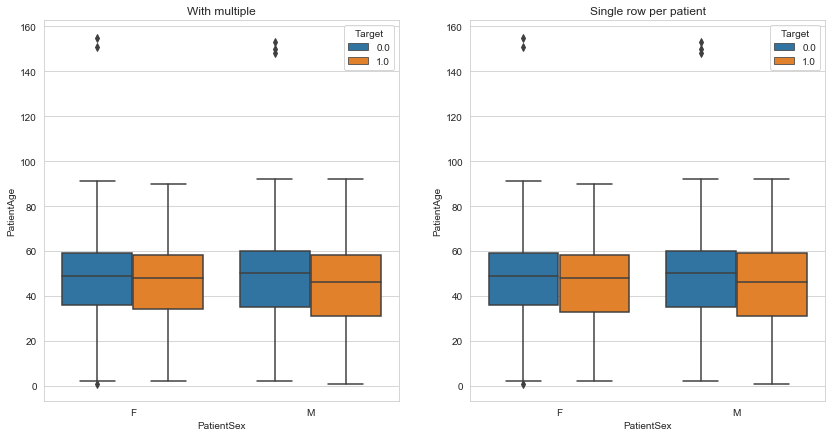

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='Target', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='Target', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

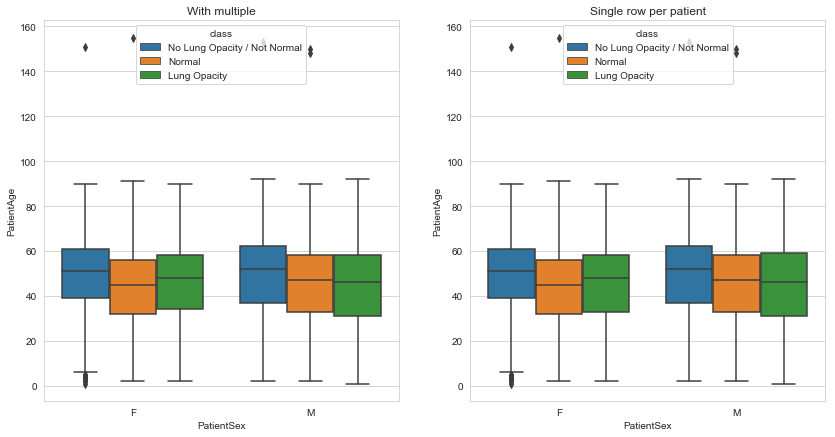

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='class', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='class', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

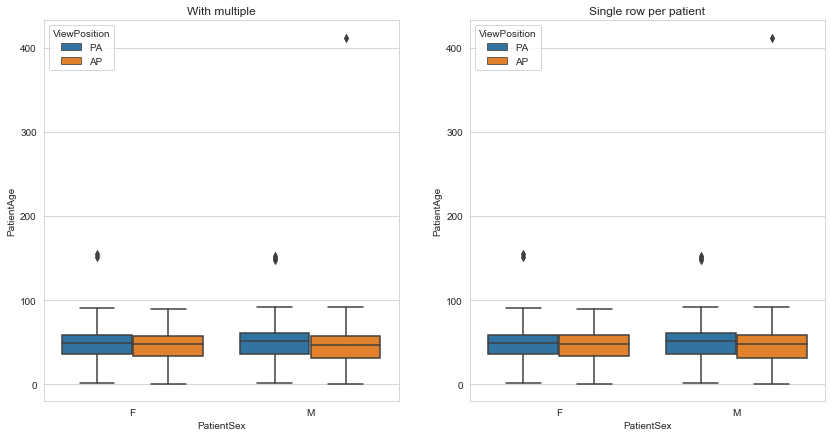

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='ViewPosition', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='ViewPosition', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

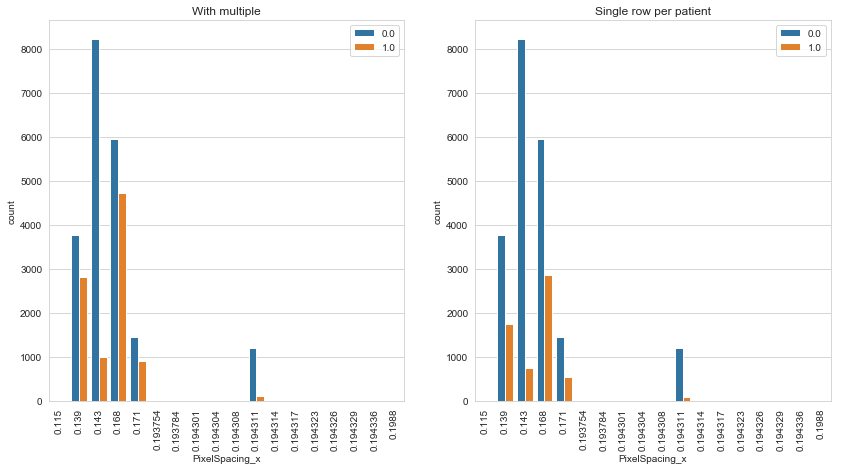

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.countplot(df['PixelSpacing_x'], hue='Target', data=df, ax=axes[0])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('With multiple')
_ = p.legend(loc='upper right')

p = sns.countplot(df_deduped['PixelSpacing_x'], hue='Target', data=df_deduped, ax=axes[1])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('Single row per patient')
_ = p.legend(loc='upper right')

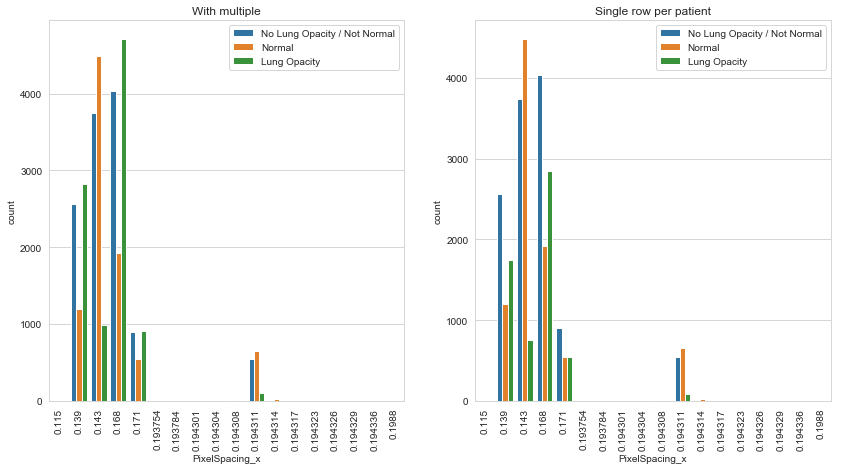

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.countplot(df['PixelSpacing_x'], hue='class', data=df, ax=axes[0])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('With multiple')
_ = p.legend(loc='upper right')

p = sns.countplot(df_deduped['PixelSpacing_x'], hue='class', data=df_deduped, ax=axes[1])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('Single row per patient')
_ = p.legend(loc='upper right')

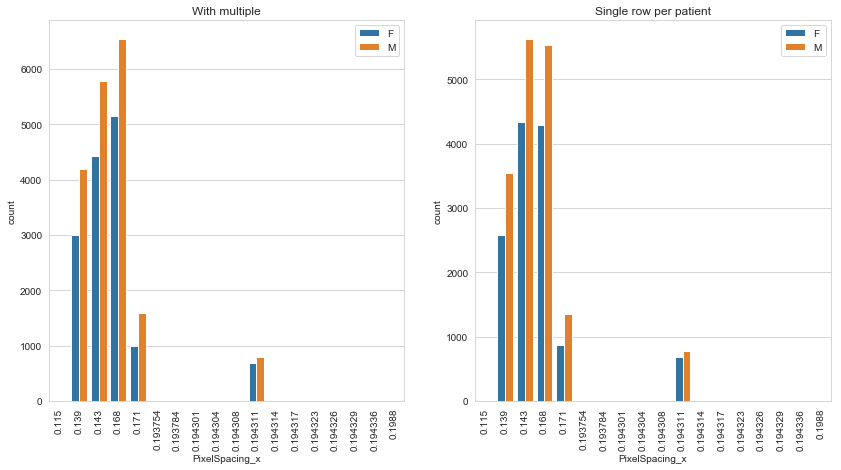

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.countplot(df['PixelSpacing_x'], hue='PatientSex', data=df, ax=axes[0])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('With multiple')
_ = p.legend(loc='upper right')

p = sns.countplot(df_deduped['PixelSpacing_x'], hue='PatientSex', data=df_deduped, ax=axes[1])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('Single row per patient')
_ = p.legend(loc='upper right')

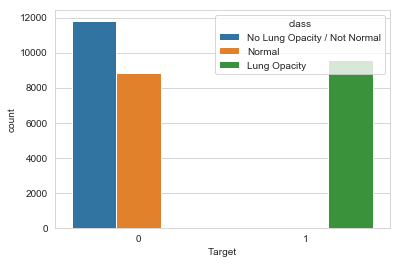

In [42]:
p = sns.countplot(x='Target', hue='class', data=labels_w_class)


In [43]:
# check every row with Target==1 has a bounding box
assert sum(labels_w_class['Target']==1) == sum(~labels_w_class['x'].isnull())

bbox_counts = labels_w_class.groupby('patientId')['Target'].sum()
labels_w_class.index = labels_w_class.patientId
labels_w_class['bbox_counts'] = bbox_counts
labels_w_class = labels_w_class.reset_index(drop=True)

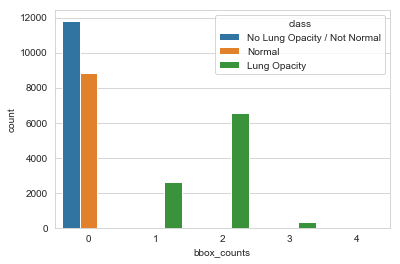

In [44]:
p = sns.countplot(x='bbox_counts', hue='class', data=labels_w_class)


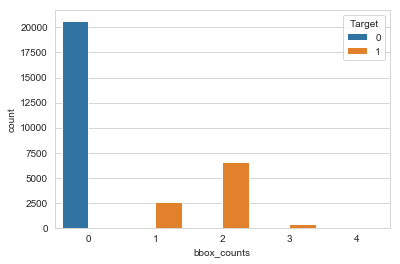

In [45]:
p = sns.countplot(x='bbox_counts', hue='Target', data=labels_w_class)


In [46]:
labels_w_class[['x', 'y', 'width', 'height']].mean()


x         394.047724
y         366.839560
width     218.471376
height    329.269702
dtype: float64

In [47]:
def build_bbox_arrays_by_id(df):
    zeros_array_constructor = partial(np.zeros, shape=(1024,1024), dtype=np.uint8)
    arrays = defaultdict(zeros_array_constructor)
    for idx, row in df.iterrows():
        patient_id = row['patientId']
        x, y = int(row['x']), int(row['y'])
        width, height = int(row['width']), int(row['height'])
        array = arrays[patient_id]
        array[y: y + height, x: x + width] += 1
    return arrays

In [48]:
bbox_arrays = build_bbox_arrays_by_id(df[df['Target']==1])


In [49]:
groups_to_ids = {
    'pa': set(df['patientId'][df['ViewPosition']=='PA'].dropna().unique()),
    'ap': set(df['patientId'][df['ViewPosition']=='AP'].dropna().unique()),
    
    'bbox_4': set(labels_w_class['patientId'][labels_w_class['bbox_counts']==4].dropna().unique()),
    'bbox_3': set(labels_w_class['patientId'][labels_w_class['bbox_counts']==3].dropna().unique()),
    'bbox_2': set(labels_w_class['patientId'][labels_w_class['bbox_counts']==2].dropna().unique()),
    'bbox_1': set(labels_w_class['patientId'][labels_w_class['bbox_counts']==1].dropna().unique()),
    
    'f': set(df['patientId'][df['PatientSex']=='F'].dropna().unique()),
    'm': set(df['patientId'][df['PatientSex']=='M'].dropna().unique()),
    
    'age_above_60': set(df['patientId'][df['PatientAge'] > 60].dropna().unique()),
    'age_40_to_60': set(df['patientId'][(df['PatientAge'] <= 60) & (df['PatientAge'] >= 40)].dropna().unique()),
    'age_below_40': set(df['patientId'][df['PatientAge'] < 40].dropna().unique()),
}

In [50]:
# construct arrays representing 'density' of bounding boxes by summing the arrays
zeros_array_constructor = partial(np.zeros, shape=(1024,1024), dtype=np.uint32)
groups_to_bbox_sums = defaultdict(zeros_array_constructor)
groups_to_bbox_sums['all'] = np.zeros(shape=(1024,1024), dtype=np.uint32)

for patient_id, bbox_array in bbox_arrays.items():
    # add to all group
    groups_to_bbox_sums['all'] += bbox_array

    # add to each other group where id is in that group's id set
    for group, id_set in groups_to_ids.items():
        if patient_id in id_set:
            groups_to_bbox_sums[group] += bbox_array

In [51]:
def plot_density(array, ax, title, n_countour_levels=3):
    contour_set = ax.contour(
        np.arange(0, 1024, 1), 
        np.arange(1024, 0, -1),
        array, 
        n_countour_levels, 
        linewidths=.5,
        colors='black'
    )
    plt.clabel(contour_set, inline=True, fontsize=10, fmt='%.0f')

    im = ax.imshow(
        array, 
        extent=[0, 1024, 0, 1024], 
        origin='upper', 
        cmap='viridis', 
        alpha=.8
    )
    plt.colorbar(im, ax=ax)
    ax.set_title(title)
    return im

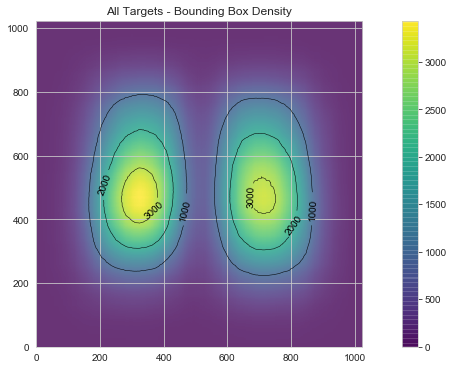

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), sharex=True)
_ = plot_density(groups_to_bbox_sums['all'], axes, 'All Targets - Bounding Box Density')

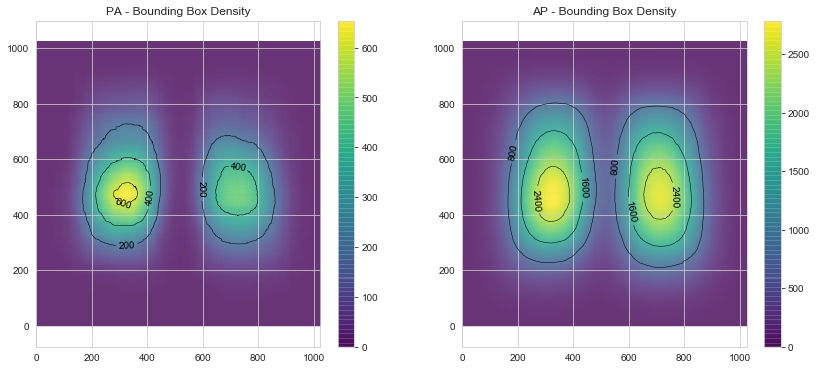

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

_ = plot_density(groups_to_bbox_sums['pa'], axes[0], 'PA - Bounding Box Density')
_ = plot_density(groups_to_bbox_sums['ap'], axes[1], 'AP - Bounding Box Density')

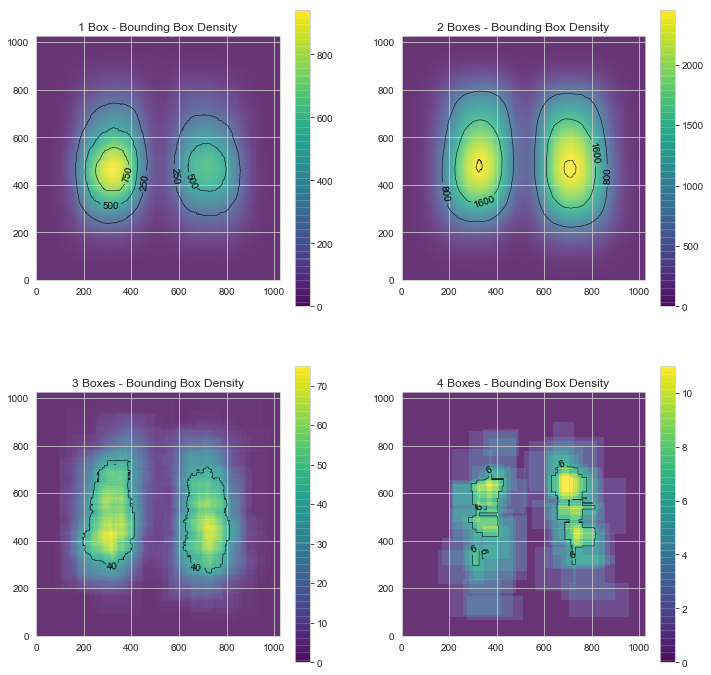

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

_ = plot_density(groups_to_bbox_sums['bbox_1'], axes[0, 0], '1 Box - Bounding Box Density', n_countour_levels=3)
_ = plot_density(groups_to_bbox_sums['bbox_2'], axes[0, 1], '2 Boxes - Bounding Box Density', n_countour_levels=3)
_ = plot_density(groups_to_bbox_sums['bbox_3'], axes[1, 0], '3 Boxes - Bounding Box Density', n_countour_levels=1)
_ = plot_density(groups_to_bbox_sums['bbox_4'], axes[1, 1], '4 Boxes - Bounding Box Density', n_countour_levels=1)

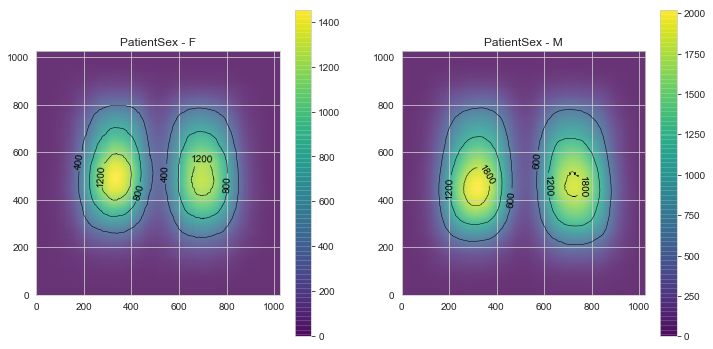

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

_ = plot_density(groups_to_bbox_sums['f'], axes[0], 'PatientSex - F', n_countour_levels=3)
_ = plot_density(groups_to_bbox_sums['m'], axes[1], 'PatientSex - M', n_countour_levels=3)


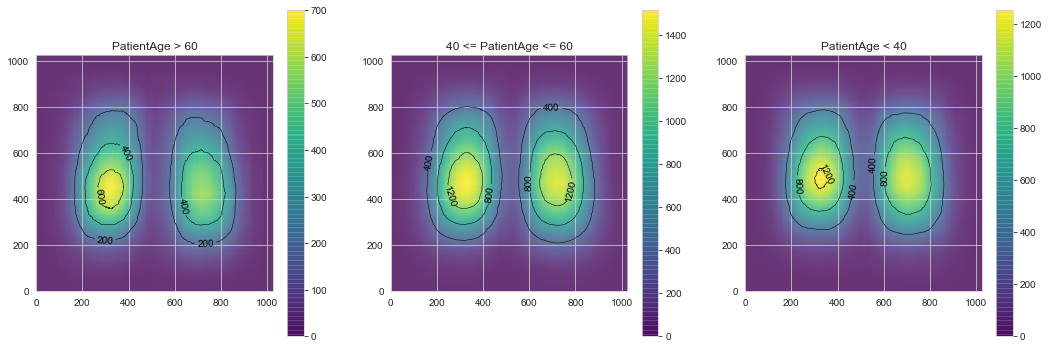

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

_ = plot_density(groups_to_bbox_sums['age_above_60'], axes[0], 'PatientAge > 60', n_countour_levels=3)
_ = plot_density(groups_to_bbox_sums['age_40_to_60'], axes[1], '40 <= PatientAge <= 60', n_countour_levels=3)
_ = plot_density(groups_to_bbox_sums['age_below_40'], axes[2], 'PatientAge < 40', n_countour_levels=3)

In [57]:
def mean_intensity(patientId):
    img = read_img(patientId)
    return np.mean(img.pixel_array)

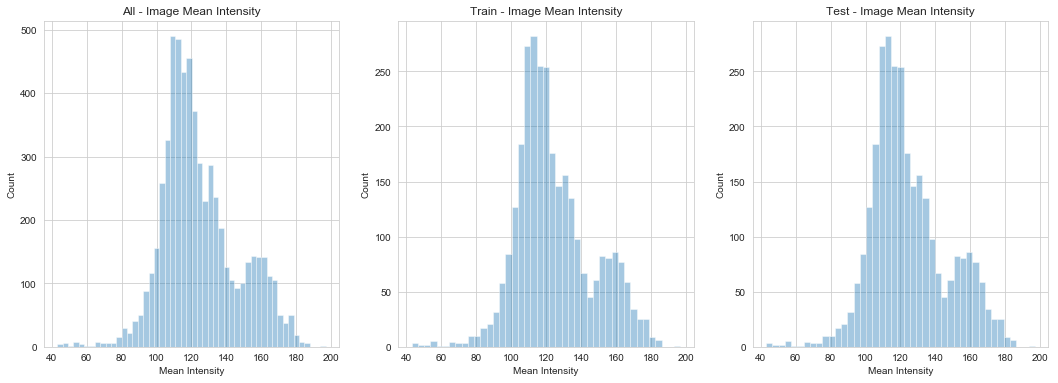

In [58]:
test_patients = df['PatientID'][df['class'].isnull()].tolist()
train_patients = df['PatientID'][df['class'].isnull()].tolist()

test_mean_intensity = Parallel(n_jobs=4)(delayed(mean_intensity)(patientId) for patientId in test_patients)
train_mean_intensity = Parallel(n_jobs=4)(delayed(mean_intensity)(patientId) for patientId in train_patients)
all_mean_intensity = test_mean_intensity + train_mean_intensity

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
p = sns.distplot(all_mean_intensity, ax=axes[0], kde=False)
_ = p.set_title('All - Image Mean Intensity')
_ = p.set_xlabel('Mean Intensity')
_ = p.set_ylabel('Count')

p = sns.distplot(train_mean_intensity, ax=axes[1], kde=False)
_ = p.set_title('Train - Image Mean Intensity')
_ = p.set_xlabel('Mean Intensity')
_ = p.set_ylabel('Count')

p = sns.distplot(test_mean_intensity, ax=axes[2], kde=False)
_ = p.set_title('Test - Image Mean Intensity')
_ = p.set_xlabel('Mean Intensity')
_ = p.set_ylabel('Count')

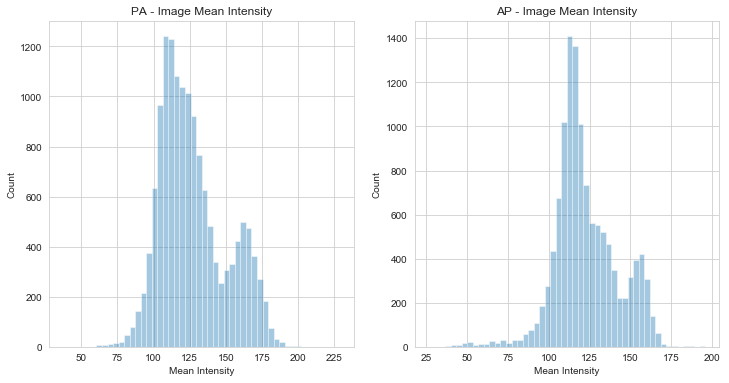

In [59]:
pa_mean_intensity = Parallel(n_jobs=4)(delayed(mean_intensity)(patientId) for patientId in groups_to_ids['pa'])
ap_mean_intensity = Parallel(n_jobs=4)(delayed(mean_intensity)(patientId) for patientId in groups_to_ids['ap'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
p = sns.distplot(pa_mean_intensity, ax=axes[0], kde=False)
_ = p.set_title('PA - Image Mean Intensity')
_ = p.set_xlabel('Mean Intensity')
_ = p.set_ylabel('Count')
p = sns.distplot(ap_mean_intensity, ax=axes[1], kde=False)
_ = p.set_title('AP - Image Mean Intensity')
_ = p.set_xlabel('Mean Intensity')
_ = p.set_ylabel('Count')

In [ ]:
df_ = df_deduped[~df_deduped['Target'].isnull()].reset_index(drop=True)
df_['patient_sex'] = df_['PatientSex'].replace({'F': 0, 'M': 1}).astype(np.int8)
df_['view_position'] = df_['ViewPosition'].replace({'AP': 0, 'PA': 1}).astype(np.int8)

In [ ]:
cv = KFold(n_splits=10, random_state=2018, shuffle=True)
oof = np.zeros(len(df_))
feats = ['patient_sex', 'PatientAge', 'view_position', 'PixelSpacing_x']

for n_fold, (train_idx, val_idx) in enumerate(cv.split(df_[feats], df_['Target'])):
    train_x, train_y = df_[feats].loc[train_idx], df_['Target'].loc[train_idx]
    val_x, val_y = df_[feats].loc[val_idx], df_['Target'].loc[val_idx]

    clf = LGBMClassifier(
        nthread=0,
        n_estimators=10000,
        learning_rate=.001,
        num_leaves=16,
        colsample_bytree=.75,
        subsample=.75,
        max_depth=5,
        reg_alpha=3,
        reg_lambda=3,
        min_child_weight=50,
        silent=-1,
        verbose=-1,
    )

    clf.fit(
        train_x, 
        train_y, 
        eval_set=[(train_x, train_y), (val_x, val_y)], 
        eval_metric='auc', 
        verbose=500, 
        early_stopping_rounds=200,
    )

    oof[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    score = roc_auc_score(val_y, oof[val_idx])
    print(f'\nFold {n_fold + 1} AUC : {score}\n')

score = roc_auc_score(df_['Target'], oof)
print(f'\nAUC on All Folds : {score}\n')